# Model intepretation

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [ ]:
# !pip install scikit-optimize
# !pip install lime

In [1]:
import pandas as pd
import numpy as np
import sklearn
import shap
import lime

#statistics
from scipy.stats import chi2_contingency, ttest_ind

# import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

#hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, RandomizedSearchCV


#performance metrices
from sklearn.metrics import precision_recall_curve, make_scorer, confusion_matrix, classification_report, f1_score, balanced_accuracy_score, r2_score, auc, average_precision_score, roc_auc_score, recall_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from cuml.svm import SVC #gpu-powered SVM


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import os

random_state = 42

In [20]:
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_ordinal.sav', 'rb'))
features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)

In [21]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   'asthmaPlan', #use the continuous one
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  48
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_not recorded', 'DeviceType_pMDI', 'PriorEducation_No', 'PriorEducation_Yes', 'age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview', 'imd_decile', 'CharlsonScore', 'BTS_step', 'BMI_cat', 'PEFStatus', 'EosinophilLevel']


In [31]:
X_cross = crossValData[features_columns]
y_cross = externalEvaluationData[['outcome_12months']]
X_grid = gridSearchData[features_columns]
X_internalVal = internalEvaluationData[features_columns]
X_externalVal = externalEvaluationData[features_columns]
y_externalVal = externalEvaluationData[['outcome_12months']]

print(X_cross.shape)
print(X_grid.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR',
    # 'DT', 'RF', 
    'XGB'
              ]

(444393, 48)
(29795, 48)
(121714, 48)
(19860, 48)


In [34]:
def summariseResult (testX, testY, model):
    preds = model.predict_proba(testX)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    return np.round(aucscore,4), np.round(auprc,4)
def process_params(param_items, best_param):
            a = eval(param_items)
            b = eval(best_param)
            c = {}
            for key, value in zip(a,b):
                c[key] = value
            return c

# Train parsimonious model

[21:20:20] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:20:20] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure


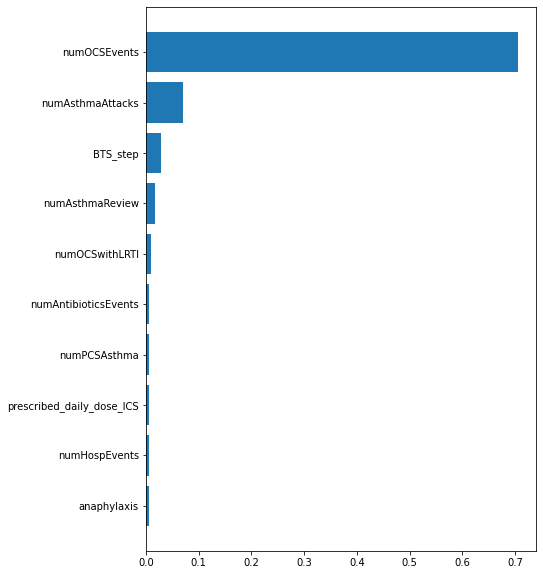

{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 58, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 10.0, 'scale_pos_weight': 18.748175182481752, 'subsample': 0.5}
[21:20:22] ======== Monitor (0): HostSketchContainer ========
[21:20:22] AllReduce: 0.006249s, 1 calls @ 6249us

[21:20:22] MakeCuts: 0.01235s, 1 calls @ 12350us

[21:20:22] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:20:22] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:20:22] ======== Monitor (0):  ========
[21:20:22] InitCompressedData: 0.000557s, 1 calls @ 557us

[21:20:52] ======== Monitor (0): Learner ========
[21:20:52] Configure: 0.001229s, 1 calls @ 1229us

[21:20:52] EvalOneIter: 0.005291s, 1000 calls @ 5291us

[21:20:52] GetGradient: 0.082338s, 1000 calls @ 82338us

[21:20:52] PredictRaw: 0.001292s, 1000 calls @ 1292us

[21:20:52] UpdateOneIter: 30.0709s, 1000 calls @ 30070862us

[21:20:52] ======== Monitor (0): GBTree ========
[21:20:52] B

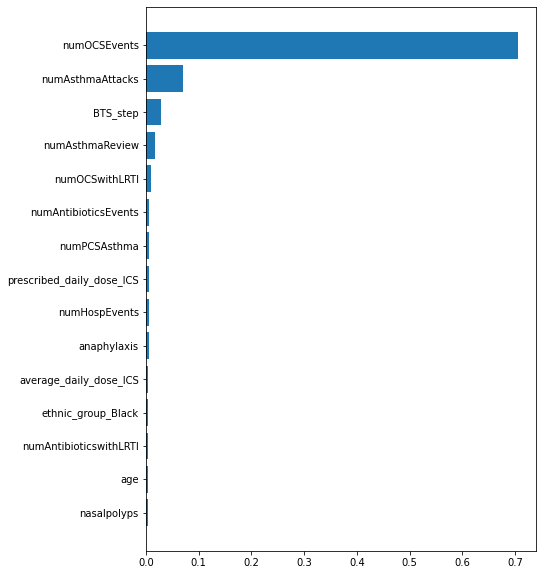

{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 58, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 10.0, 'scale_pos_weight': 18.748175182481752, 'subsample': 0.5}
[21:20:53] ======== Monitor (0): HostSketchContainer ========
[21:20:53] AllReduce: 0.006795s, 1 calls @ 6795us

[21:20:53] MakeCuts: 0.015508s, 1 calls @ 15508us

[21:20:53] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:20:53] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:20:53] ======== Monitor (0):  ========
[21:20:53] InitCompressedData: 0.000724s, 1 calls @ 724us

[21:22:08] ======== Monitor (0): Learner ========
[21:22:08] Configure: 0.000929s, 1 calls @ 929us

[21:22:08] EvalOneIter: 0.007283s, 1000 calls @ 7283us

[21:22:08] GetGradient: 0.108639s, 1000 calls @ 108639us

[21:22:08] PredictRaw: 0.001832s, 1000 calls @ 1832us

[21:22:08] UpdateOneIter: 73.7514s, 1000 calls @ 73751447us

[21:22:08] ======== Monitor (0): GBTree ========
[21:22:08] 

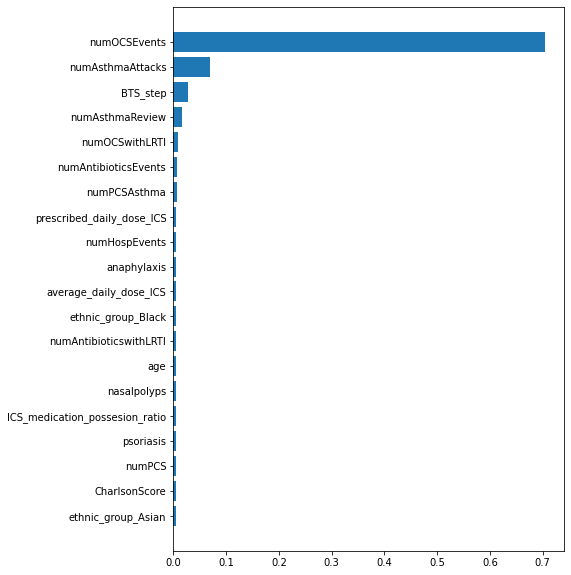

{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 58, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 10.0, 'scale_pos_weight': 18.748175182481752, 'subsample': 0.5}
[21:22:10] ======== Monitor (0): HostSketchContainer ========
[21:22:10] AllReduce: 0.011327s, 1 calls @ 11327us

[21:22:10] MakeCuts: 0.017514s, 1 calls @ 17514us

[21:22:10] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:22:10] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:22:10] ======== Monitor (0):  ========
[21:22:10] InitCompressedData: 0.001341s, 1 calls @ 1341us

[21:23:58] ======== Monitor (0): Learner ========
[21:23:58] Configure: 0.001516s, 1 calls @ 1516us

[21:23:58] EvalOneIter: 0.006193s, 1000 calls @ 6193us

[21:23:58] GetGradient: 0.088472s, 1000 calls @ 88472us

[21:23:58] PredictRaw: 0.001355s, 1000 calls @ 1355us

[21:23:58] UpdateOneIter: 107.456s, 1000 calls @ 107455730us

[21:23:58] ======== Monitor (0): GBTree ========
[21:23:5

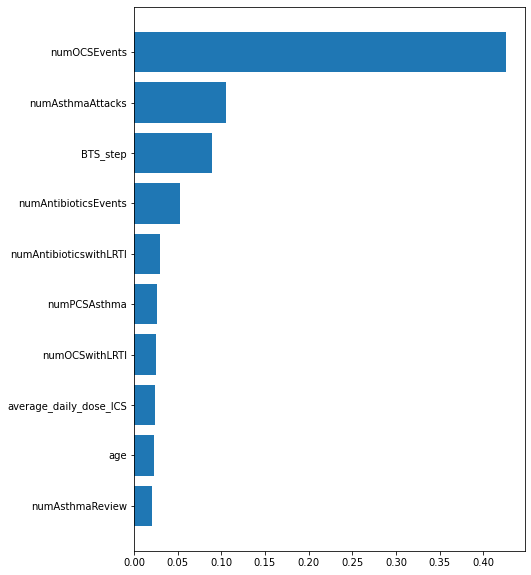

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:00] ======== Monitor (0): HostSketchContainer ========
[21:24:00] AllReduce: 0.004487s, 1 calls @ 4487us

[21:24:00] MakeCuts: 0.01294s, 1 calls @ 12940us

[21:24:00] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:00] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:00] ======== Monitor (0):  ========
[21:24:00] InitCompressedData: 0.001172s, 1 calls @ 1172us

[21:24:05] ======== Monitor (0): Learner ========
[21:24:05] Configure: 0.001556s, 1 calls @ 1556us

[21:24:05] EvalOneIter: 0.002976s, 897 calls @ 2976us

[21:24:05] GetGradient: 0.076497s, 897 calls @ 76497us

[21:24:05] PredictRaw: 0.000813s, 897 calls @ 813us

[21:24:05] UpdateOneIter: 5.03298s, 897 calls @ 503298

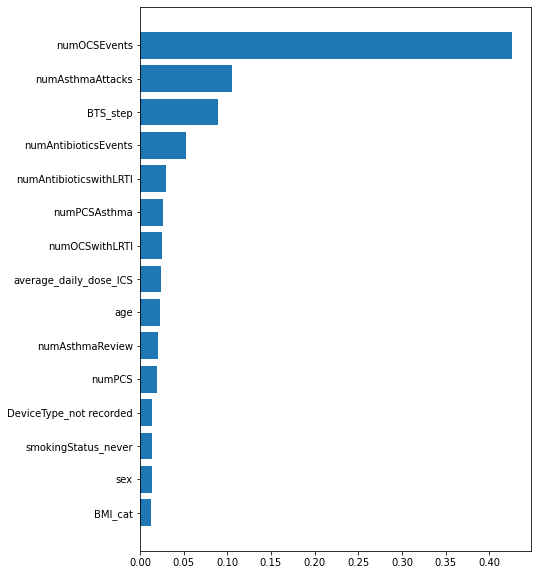

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:06] ======== Monitor (0): HostSketchContainer ========
[21:24:06] AllReduce: 0.002601s, 1 calls @ 2601us

[21:24:06] MakeCuts: 0.013081s, 1 calls @ 13081us

[21:24:06] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:06] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:06] ======== Monitor (0):  ========
[21:24:06] InitCompressedData: 0.000704s, 1 calls @ 704us

[21:24:11] ======== Monitor (0): Learner ========
[21:24:11] Configure: 0.003181s, 1 calls @ 3181us

[21:24:11] EvalOneIter: 0.002682s, 897 calls @ 2682us

[21:24:11] GetGradient: 0.072738s, 897 calls @ 72738us

[21:24:11] PredictRaw: 0.000785s, 897 calls @ 785us

[21:24:11] UpdateOneIter: 4.91855s, 897 calls @ 491854

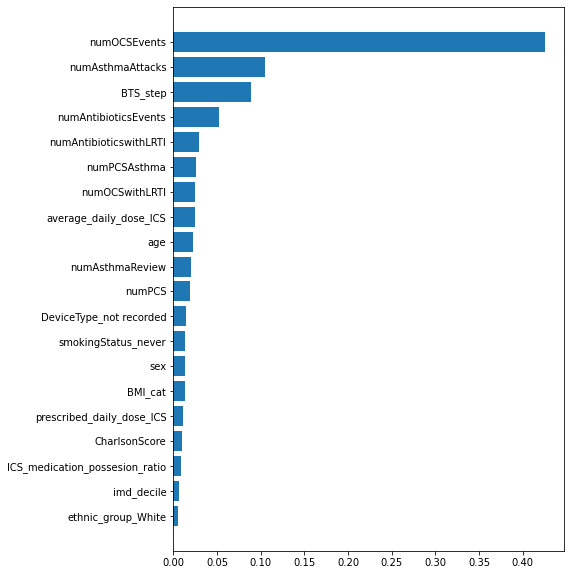

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:11] ======== Monitor (0): HostSketchContainer ========
[21:24:11] AllReduce: 0.010105s, 1 calls @ 10105us

[21:24:11] MakeCuts: 0.015427s, 1 calls @ 15427us

[21:24:11] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:11] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:11] ======== Monitor (0):  ========
[21:24:11] InitCompressedData: 0.000862s, 1 calls @ 862us

[21:24:16] ======== Monitor (0): Learner ========
[21:24:16] Configure: 0.001035s, 1 calls @ 1035us

[21:24:16] EvalOneIter: 0.00263s, 897 calls @ 2630us

[21:24:16] GetGradient: 0.07258s, 897 calls @ 72580us

[21:24:16] PredictRaw: 0.0007s, 897 calls @ 700us

[21:24:16] UpdateOneIter: 4.96269s, 897 calls @ 4962692us

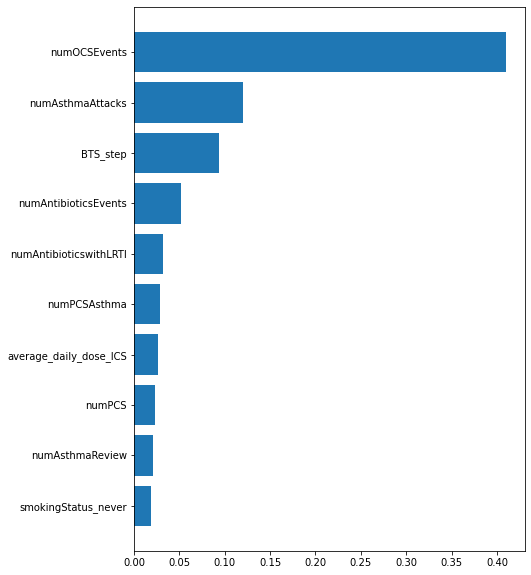

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:17] ======== Monitor (0): HostSketchContainer ========
[21:24:17] AllReduce: 0.002788s, 1 calls @ 2788us

[21:24:17] MakeCuts: 0.010263s, 1 calls @ 10263us

[21:24:17] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:17] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:17] ======== Monitor (0):  ========
[21:24:17] InitCompressedData: 0.000645s, 1 calls @ 645us

[21:24:21] ======== Monitor (0): Learner ========
[21:24:21] Configure: 0.00186s, 1 calls @ 1860us

[21:24:21] EvalOneIter: 0.002924s, 897 calls @ 2924us

[21:24:21] GetGradient: 0.074001s, 897 calls @ 74001us

[21:24:21] PredictRaw: 0.000785s, 897 calls @ 785us

[21:24:21] UpdateOneIter: 4.53667s, 897 calls @ 4536668

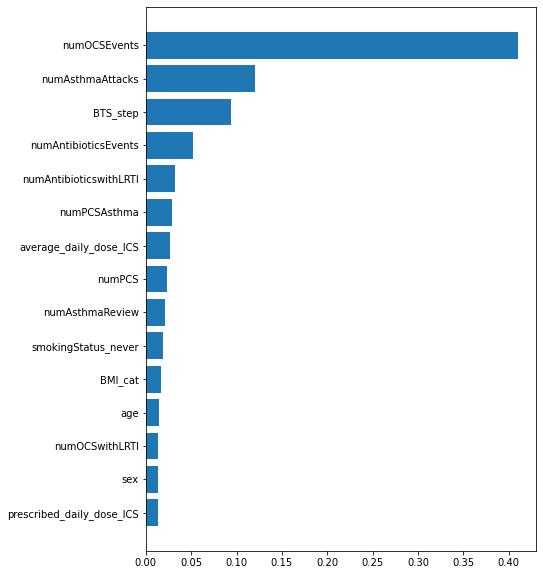

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:22] ======== Monitor (0): HostSketchContainer ========
[21:24:22] AllReduce: 0.002763s, 1 calls @ 2763us

[21:24:22] MakeCuts: 0.010763s, 1 calls @ 10763us

[21:24:22] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:22] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:22] ======== Monitor (0):  ========
[21:24:22] InitCompressedData: 0.000687s, 1 calls @ 687us

[21:24:27] ======== Monitor (0): Learner ========
[21:24:27] Configure: 0.001422s, 1 calls @ 1422us

[21:24:27] EvalOneIter: 0.002832s, 897 calls @ 2832us

[21:24:27] GetGradient: 0.073897s, 897 calls @ 73897us

[21:24:27] PredictRaw: 0.000757s, 897 calls @ 757us

[21:24:27] UpdateOneIter: 4.8164s, 897 calls @ 4816396

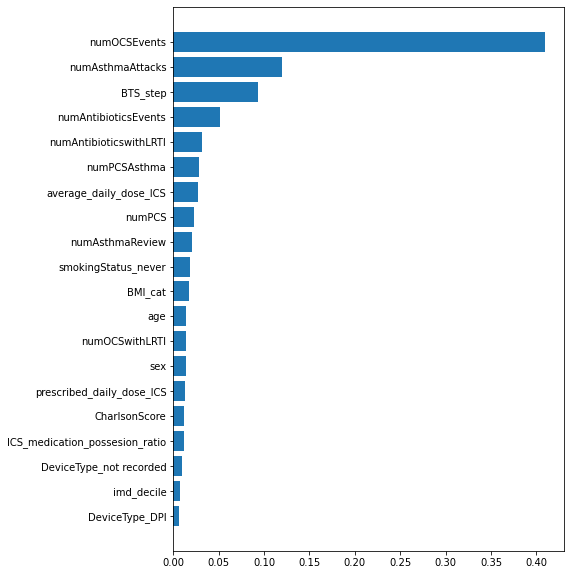

{'colsample_bytree': 0.5176005281917953, 'learning_rate': 0.006007740779300901, 'max_depth': 5, 'n_estimators': 897, 'reg_alpha': 0.13307206316161288, 'reg_lambda': 0.4740701401022268, 'scale_pos_weight': 15.23769518929258, 'subsample': 0.9791794210208937}
[21:24:27] ======== Monitor (0): HostSketchContainer ========
[21:24:27] AllReduce: 0.009049s, 1 calls @ 9049us

[21:24:27] MakeCuts: 0.014276s, 1 calls @ 14276us

[21:24:27] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:27] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:27] ======== Monitor (0):  ========
[21:24:27] InitCompressedData: 0.000886s, 1 calls @ 886us

[21:24:32] ======== Monitor (0): Learner ========
[21:24:32] Configure: 0.001039s, 1 calls @ 1039us

[21:24:32] EvalOneIter: 0.002691s, 897 calls @ 2691us

[21:24:32] GetGradient: 0.073228s, 897 calls @ 73228us

[21:24:32] PredictRaw: 0.000738s, 897 calls @ 738us

[21:24:32] UpdateOneIter: 4.89903s, 897 calls @ 489902

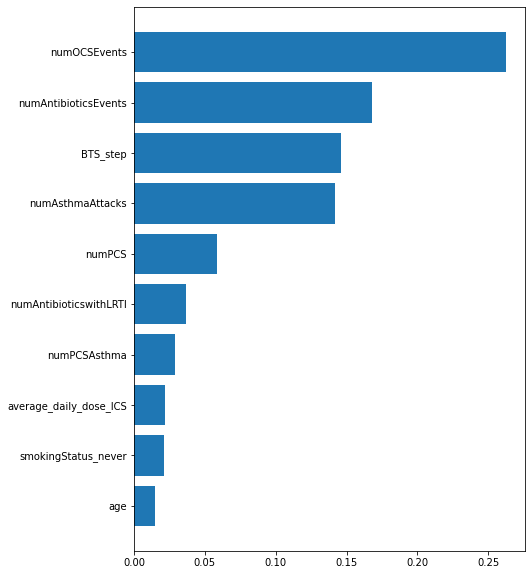

{'colsample_bytree': 0.5, 'learning_rate': 0.021211820714260574, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 0.1, 'scale_pos_weight': 9.691656942823805, 'subsample': 0.5}
[21:24:33] ======== Monitor (0): HostSketchContainer ========
[21:24:33] AllReduce: 0.007376s, 1 calls @ 7376us

[21:24:33] MakeCuts: 0.014026s, 1 calls @ 14026us

[21:24:33] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:33] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:33] ======== Monitor (0):  ========
[21:24:33] InitCompressedData: 0.000656s, 1 calls @ 656us

[21:24:36] ======== Monitor (0): Learner ========
[21:24:36] Configure: 0.001239s, 1 calls @ 1239us

[21:24:36] EvalOneIter: 0.002925s, 1000 calls @ 2925us

[21:24:36] GetGradient: 0.086702s, 1000 calls @ 86702us

[21:24:36] PredictRaw: 0.000848s, 1000 calls @ 848us

[21:24:36] UpdateOneIter: 3.24277s, 1000 calls @ 3242770us

[21:24:36] ======== Monitor (0): GBTree ========
[

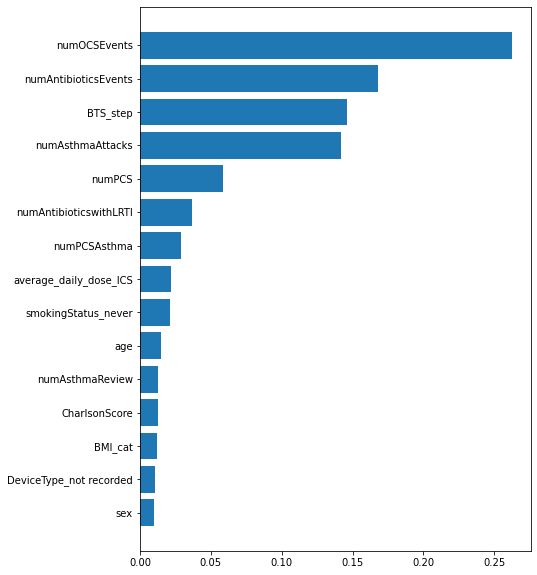

{'colsample_bytree': 0.5, 'learning_rate': 0.021211820714260574, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 0.1, 'scale_pos_weight': 9.691656942823805, 'subsample': 0.5}
[21:24:36] ======== Monitor (0): HostSketchContainer ========
[21:24:36] AllReduce: 0.008801s, 1 calls @ 8801us

[21:24:36] MakeCuts: 0.013901s, 1 calls @ 13901us

[21:24:36] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:36] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:36] ======== Monitor (0):  ========
[21:24:36] InitCompressedData: 0.000712s, 1 calls @ 712us

[21:24:40] ======== Monitor (0): Learner ========
[21:24:40] Configure: 0.001033s, 1 calls @ 1033us

[21:24:40] EvalOneIter: 0.003026s, 1000 calls @ 3026us

[21:24:40] GetGradient: 0.089353s, 1000 calls @ 89353us

[21:24:40] PredictRaw: 0.00086s, 1000 calls @ 860us

[21:24:40] UpdateOneIter: 3.78017s, 1000 calls @ 3780165us

[21:24:40] ======== Monitor (0): GBTree ========
[2

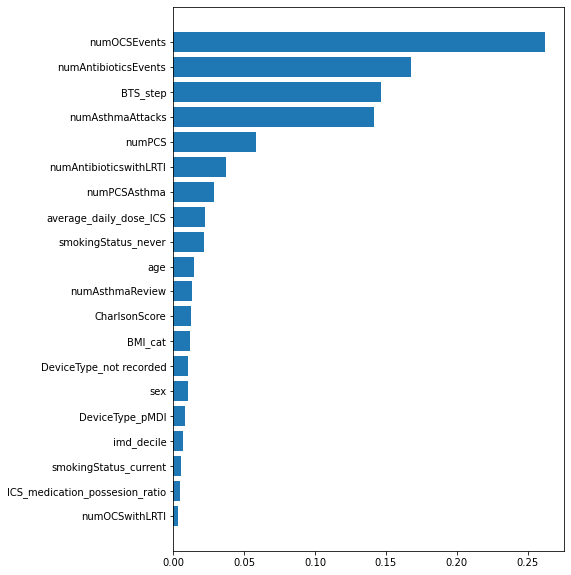

{'colsample_bytree': 0.5, 'learning_rate': 0.021211820714260574, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 0.1, 'scale_pos_weight': 9.691656942823805, 'subsample': 0.5}
[21:24:41] ======== Monitor (0): HostSketchContainer ========
[21:24:41] AllReduce: 0.010279s, 1 calls @ 10279us

[21:24:41] MakeCuts: 0.01141s, 1 calls @ 11410us

[21:24:41] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:24:41] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:24:41] ======== Monitor (0):  ========
[21:24:41] InitCompressedData: 0.000886s, 1 calls @ 886us

[21:24:44] ======== Monitor (0): Learner ========
[21:24:44] Configure: 0.001442s, 1 calls @ 1442us

[21:24:44] EvalOneIter: 0.00251s, 1000 calls @ 2510us

[21:24:44] GetGradient: 0.085855s, 1000 calls @ 85855us

[21:24:44] PredictRaw: 0.000761s, 1000 calls @ 761us

[21:24:44] UpdateOneIter: 3.80113s, 1000 calls @ 3801132us

[21:24:44] ======== Monitor (0): GBTree ========
[2

In [25]:
results = []
for outcome in target_outcomes:
    best_model = pickle.load(open('../../MODELS/TestResultOrdinal/'+outcome+'_XGB.sav', 'rb'))
    n_features = [10,15,20] #number of top important features will be incorporated into the model
    AUC, AUPRC = summariseResult(X_externalVal, y_externalVal, best_model)
    results.append([outcome, 'original_model', AUC, AUPRC])
    for n in n_features:
        #extract n-important features 10,15,20
        sorted_idx = best_model.feature_importances_.argsort()
        plt.figure(figsize=(7,10))
        plt.barh(X_cross.columns[sorted_idx][-n:], best_model.feature_importances_[sorted_idx][-n:])
        plt.xlabel
        plt.show()
        topnfeatures = X_cross.columns[sorted_idx][-n:]
        # top15features = X.columns[sorted_idx][-15:]
        # top20features = X.columns[sorted_idx][-20:]

        #params
        params_dict = pd.read_csv('../../MODELS/BS_result_new.csv')
        def process_params(param_items, best_param):
            a = eval(param_items)
            b = eval(best_param)
            c = {}
            for key, value in zip(a,b):
                c[key] = value
            return c
        
        params_dict['params'] = params_dict.apply(lambda x: dict(eval(x.best_param[11:])), axis=1)


        #retrain XGB model using subset of n-features
        model = 'XGB'
        params = params_dict[(params_dict['outcome']==outcome)&(params_dict['model']==model)]['params'].tolist()[0]
        # params = eval(params)
        print(params)
        scale_pos_ratio = y_cross.value_counts()[0]/y_cross.value_counts()[1]
        xgb_model = xgb.XGBClassifier(objective ='binary:logistic', tree_method = "hist", 
                                      n_estimators=params['n_estimators'],
                                      max_depth=params['max_depth'],
                                      learning_rate=params['learning_rate'],
                                      reg_alpha=params['reg_alpha'],
                                      reg_lambda=params['reg_lambda'],
                                      # subsample=params['subsample'],
                                      # colsample_bytree=params['colsample_bytree'],
                                      # scale_pos_weight=params['scale_pos_weight'],
                                      scale_pos_weight=scale_pos_ratio,
                                      device = "cuda", 
                                      verbosity = 3,
                                      # importance_type = 'gain', 
                                      random_state=random_state)
        
        xgb_model.fit(crossValData[topnfeatures], crossValData[[outcome]])
        AUC, AUPRC = summariseResult(externalEvaluationData[topnfeatures], externalEvaluationData[[outcome]], xgb_model)
        results.append([outcome, n, AUC, AUPRC])
        pickle.dump(xgb_model, open('../../MODELS/parsimoniousModel/'+outcome+'XGB_parsimoniousModel_'+str(n)+'.sav', 'wb'))    


In [29]:
results = pd.DataFrame(results, columns=['outcome', 'n_features', 'AUC', 'AUPRC'])
results[results.outcome=='outcome_12months']

,outcome,n_features,AUC,AUPRC
12,outcome_12months,original_model,0.7885,0.4559
13,outcome_12months,10,0.7857,0.4507
14,outcome_12months,15,0.7867,0.4533
15,outcome_12months,20,0.7886,0.4571


In [36]:
results = []
for outcome in target_outcomes:
    for model in model_names:
        best_model = pickle.load(open('../../MODELS/TestResultOrdinal/'+outcome+'_'+model+'.sav', 'rb'))
        n_features = [10,15,20] #number of top important features will be incorporated into the model
        AUC, AUPRC = summariseResult(X_externalVal, y_externalVal, best_model)
        results.append([outcome, model, 'original_model', AUC, AUPRC])
        #params
        params_dict = pd.read_csv('../../MODELS/BS_result_new.csv')
        params_dict['params'] = params_dict.apply(lambda x: dict(eval(x.best_param[11:])), axis=1)
        for n in n_features:
            if model == 'XGB':
                #extract n-important features 10,15,20
                sorted_idx = best_model.feature_importances_.argsort()
                # plt.figure(figsize=(7,10))
                # plt.barh(X_cross.columns[sorted_idx][-n:], best_model.feature_importances_[sorted_idx][-n:])
                # plt.xlabel
                # plt.show()
                topnfeatures = X_cross.columns[sorted_idx][-n:]

                #retrain model using subset of n-features
                params = params_dict[(params_dict['outcome']==outcome)&(params_dict['model']==model)]['params'].tolist()[0]
                scale_pos_ratio = y_cross.value_counts()[0]/y_cross.value_counts()[1]
                trained_model = xgb.XGBClassifier(objective ='binary:logistic', tree_method = "hist", 
                                              n_estimators=params['n_estimators'],
                                              max_depth=params['max_depth'],
                                              learning_rate=params['learning_rate'],
                                              reg_alpha=params['reg_alpha'],
                                              reg_lambda=params['reg_lambda'],
                                              # subsample=params['subsample'],
                                              # colsample_bytree=params['colsample_bytree'],
                                              # scale_pos_weight=params['scale_pos_weight'],
                                              scale_pos_weight=scale_pos_ratio,
                                              device = "cuda", 
                                              verbosity = 3,
                                              # importance_type = 'gain', 
                                              random_state=random_state)
            elif model=='LR':
                sorted_idx = best_model.coef_[0].argsort()
                topnfeatures = X_cross.columns[sorted_idx][-n:]
                #retrain model
                params = params_dict[(params_dict['outcome']==outcome)&(params_dict['model']==model)]['params'].tolist()[0]
                trained_model = LogisticRegression(class_weight='balanced', C = params['C'], max_iter=params['max_iter'], solver=params['solver'], random_state=random_state)
        
            
            trained_model.fit(crossValData[topnfeatures], crossValData[[outcome]])
            AUC, AUPRC = summariseResult(externalEvaluationData[topnfeatures], externalEvaluationData[[outcome]], trained_model)
            results.append([outcome, model, n, AUC, AUPRC])
            pickle.dump(trained_model, open('../../MODELS/parsimoniousModel/more/'+outcome+'_'+model+'_parsimoniousModel_'+str(n)+'.sav', 'wb'))    


/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:39:48] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:39:48] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:39:49] ======== Monitor (0): HostSketchContainer ========
[21:39:49] AllReduce: 0.006307s, 1 calls @ 6307us

[21:39:49] MakeCuts: 0.012001s, 1 calls @ 12001us

[21:39:49] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:39:49] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:39:49] ======== Monitor (0):  ========
[21:39:49] InitCompressedData: 0.000581s, 1 calls @ 581us

[21:40:19] ======== Monitor (0): Learner ========
[21:40:19] Configure: 0.000857s, 1 calls @ 857us

[21:40:19] EvalOneIter: 0.00527s, 1000 calls @ 5270us

[21:40:19] GetGradient: 0.082081s, 1000 calls @ 82081us

[21:40:19] PredictRaw: 0.001217s, 1000 calls @ 1217us

[21:40:19] UpdateOneIter: 29.7518s, 1000 calls @ 29751781us

[21:40:19] ======== Monitor (0): GBTree ========
[21:40:19] BoostNewTrees: 29.3688s, 1000 

/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:43:31] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:43:31] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:43:31] ======== Monitor (0): HostSketchContainer ========
[21:43:31] AllReduce: 0.009764s, 1 calls @ 9764us

[21:43:31] MakeCuts: 0.016408s, 1 calls @ 16408us

[21:43:31] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:43:31] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:43:31] ======== Monitor (0):  ========
[21:43:31] InitCompressedData: 0.001486s, 1 calls @ 1486us

[21:43:36] ======== Monitor (0): Learner ========
[21:43:36] Configure: 0.001719s, 1 calls @ 1719us

[21:43:36] EvalOneIter: 0.003102s, 897 calls @ 3102us

[21:43:36] GetGradient: 0.076362s, 897 calls @ 76362us

[21:43:36] PredictRaw: 0.000822s, 897 calls @ 822us

[21:43:36] UpdateOneIter: 5.08363s, 897 calls @ 5083628us

[21:43:36] ======== Monitor (0): GBTree ========
[21:43:36] BoostNewTrees: 4.71746s, 897 call

/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:43:51] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:43:51] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:43:52] ======== Monitor (0): HostSketchContainer ========
[21:43:52] AllReduce: 0.003194s, 1 calls @ 3194us

[21:43:52] MakeCuts: 0.008421s, 1 calls @ 8421us

[21:43:52] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:43:52] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:43:52] ======== Monitor (0):  ========
[21:43:52] InitCompressedData: 0.001626s, 1 calls @ 1626us

[21:43:57] ======== Monitor (0): Learner ========
[21:43:57] Configure: 0.001655s, 1 calls @ 1655us

[21:43:57] EvalOneIter: 0.002711s, 897 calls @ 2711us

[21:43:57] GetGradient: 0.072364s, 897 calls @ 72364us

[21:43:57] PredictRaw: 0.000719s, 897 calls @ 719us

[21:43:57] UpdateOneIter: 4.95272s, 897 calls @ 4952717us

[21:43:57] ======== Monitor (0): GBTree ========
[21:43:57] BoostNewTrees: 4.58112s, 897 calls

/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:44:11] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:44:11] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:44:12] ======== Monitor (0): HostSketchContainer ========
[21:44:12] AllReduce: 0.009896s, 1 calls @ 9896us

[21:44:12] MakeCuts: 0.018421s, 1 calls @ 18421us

[21:44:12] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[21:44:12] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
[21:44:12] ======== Monitor (0):  ========
[21:44:12] InitCompressedData: 0.001604s, 1 calls @ 1604us

[21:44:15] ======== Monitor (0): Learner ========
[21:44:15] Configure: 0.001809s, 1 calls @ 1809us

[21:44:15] EvalOneIter: 0.002544s, 1000 calls @ 2544us

[21:44:15] GetGradient: 0.081161s, 1000 calls @ 81161us

[21:44:15] PredictRaw: 0.000682s, 1000 calls @ 682us

[21:44:15] UpdateOneIter: 3.82362s, 1000 calls @ 3823624us

[21:44:15] ======== Monitor (0): GBTree ========
[21:44:15] BoostNewTrees: 3.4295s, 1000 

In [37]:
results = pd.DataFrame(results, columns=['outcome', 'model', 'n_features', 'AUC', 'AUPRC'])


In [39]:
results[results.outcome=='outcome_12months']

,outcome,model,n_features,AUC,AUPRC
24,outcome_12months,LR,original_model,0.7539,0.4063
25,outcome_12months,LR,10,0.7439,0.4009
26,outcome_12months,LR,15,0.7461,0.4028
27,outcome_12months,LR,20,0.7474,0.4028
28,outcome_12months,XGB,original_model,0.7885,0.4559
29,outcome_12months,XGB,10,0.7857,0.4507
30,outcome_12months,XGB,15,0.7867,0.4533
31,outcome_12months,XGB,20,0.7886,0.4571


In [40]:
topnfeatures

Index(['numOCSwithLRTI', 'ICS_medication_possesion_ratio',
       'smokingStatus_current', 'imd_decile', 'DeviceType_pMDI', 'sex',
       'DeviceType_not recorded', 'BMI_cat', 'CharlsonScore',
       'numAsthmaReview', 'age', 'smokingStatus_never',
       'average_daily_dose_ICS', 'numPCSAsthma', 'numAntibioticswithLRTI',
       'numPCS', 'numAsthmaAttacks', 'BTS_step', 'numAntibioticsEvents',
       'numOCSEvents'],
      dtype='object')